<a href="https://colab.research.google.com/github/TechT3o/NeRF_hw_implementation/blob/main/Simple_NeRF_Torch_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 239AS Problem Set 3

# Imports

In [ ]:
import os
from google.colab import drive

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

In [ ]:
# !gdown https://drive.google.com/uc?id=1uPSqGZdmZt-b5YLMWscad6ST3MLBNESk
# !unzip sol.zip

Downloading...
From: https://drive.google.com/uc?id=1uPSqGZdmZt-b5YLMWscad6ST3MLBNESk
To: /content/sol.zip
100% 57.1k/57.1k [00:00<00:00, 128MB/s]
Archive:  sol.zip
replace sol/cornell_box.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
def check_code_correctness(test_function, *test_in, test_outs):
    """Checks if the given function behaves as expected

    Args:
      test_function: Function to test
      *test_in: The sample inputs to test on (can be multiple)
      test_out: The expected output of the function given the specified input

    Returns:
      True if the function behaves as expected, False otherwise (wrong answer or error)
    """
    try:
        # Using *test_in to unpack the arguments and pass to the test_function
        student_outputs = test_function(*test_in)
        # Ensure student_outputs is a tuple for easier comparison
        if not isinstance(student_outputs, tuple):
            student_outputs = (student_outputs,)
    except NotImplementedError as err:
        print("Please implement and remove 'raise NotImplementedError'")
        return False
    except RuntimeError as err:
        print("Please make sure you have the right dimensions and type")
        return False
    except:
        print("An exception occurred: could not compute output")
        return False

    try:
        for student_out, test_out in zip(student_outputs, test_outs):
            if not np.allclose(student_out, test_out):
                print("Test failed, student output does not match test output")
                return False
    except TypeError as err:
        print("Please make sure your function outputs the correct type")
        return False
    except:
        print("An exception occurred: could not check output")
        return False

    return True

# 0 Introduction to NeRF and Pytorch

## 0.1 NeRF Introduction

**0.1.1 Intuition of NeRF**

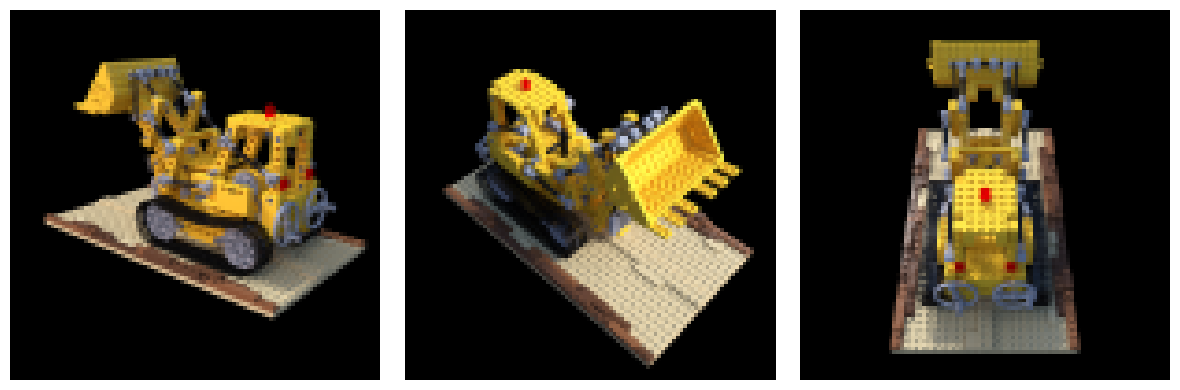

Before we implement NeRF, let's introduce the idea and intuition behind it.

Imagine you have an object (a phone, an article of clothing, a yellow lego tractor) in the real world that you want display online. One's first intuition may be to take a picture of the front of the item and then post that. Others may take photos of the item at different angles. Some may take a video around the object to allow even more angles to view it. However, each of these techniques fall short in the same way: given a finite amount of pictures/frames, you can only get a finite amount of ways to view it.

This is where Neural Radiance Fields (NeRF) comes in. The main application of NeRF is novel view synthesis -- being able to create new poses or views of an object. This has major implicatons: given a finite amount of pictures/frames, you can get an infinite amount of ways to view it.

While novel view synthesis may not seem that important on its own, it has many implications in computer vision and computational imaging. When humans look at objects, we have an understanding of what different views of the object are (back, top, side) based on our previous experiences with it. Thus, if we want to create a machine that can interpret and understand 3D real world scenes, we must incorporate a way for the machine to understand not observed views of objects.

Another implication of this is surface reconstruction, which was introduced in the paper "NeuS: Learning Neural Implicit Surfaces by Volume Rendering for Multi-view Reconstruction". Given 2D images of a scene, this neural network is able to create an SDF that we can extract a mesh from using marching cubes. This mesh can then be imported to Blender.

**High-Level Overview of NeRF**

So how does NeRF work? We will use the following analogy throughout this notebook:

Imagine you are trying to paint a picture, but instead of using a brush, you shine light through a foggy room and capture the colors that come out on the other side. The more fog (or "stuff") there is in a particular spot, the more it affects the color of the light. If there's a lot of fog, we might not even see the light that comes from behind it. To paint a specific view of the scene, you anchor your flashlight somewhere and shine it into the fog. The light that comes out of the fog is dependent on the color and fog density at different points along the flashlight's beams. You can create different views of the fog by shining the flashlight at different angles and positions (you can't change the fog).

Now, let's apply this analogy to the yellow lego tractor. Here, our scene is the lego tractor. Instead of using a flashlight, we use a camera to "shoot" rays that travel across the scene. As we only have pictures, we use a neural network to "simulate" what the rgb and density/opacity of the scene is at different points. We then use alpha blending to turn these rgb and density/opacity values into an image. We can train the neural network by minimizing the difference between an image of the scene at a specific viewing position and angle and the reconstructed image from the neural network given the viewing parameters.

The end result is the following function: given a camera angle and position, we can produce an image of the scene from that angle.

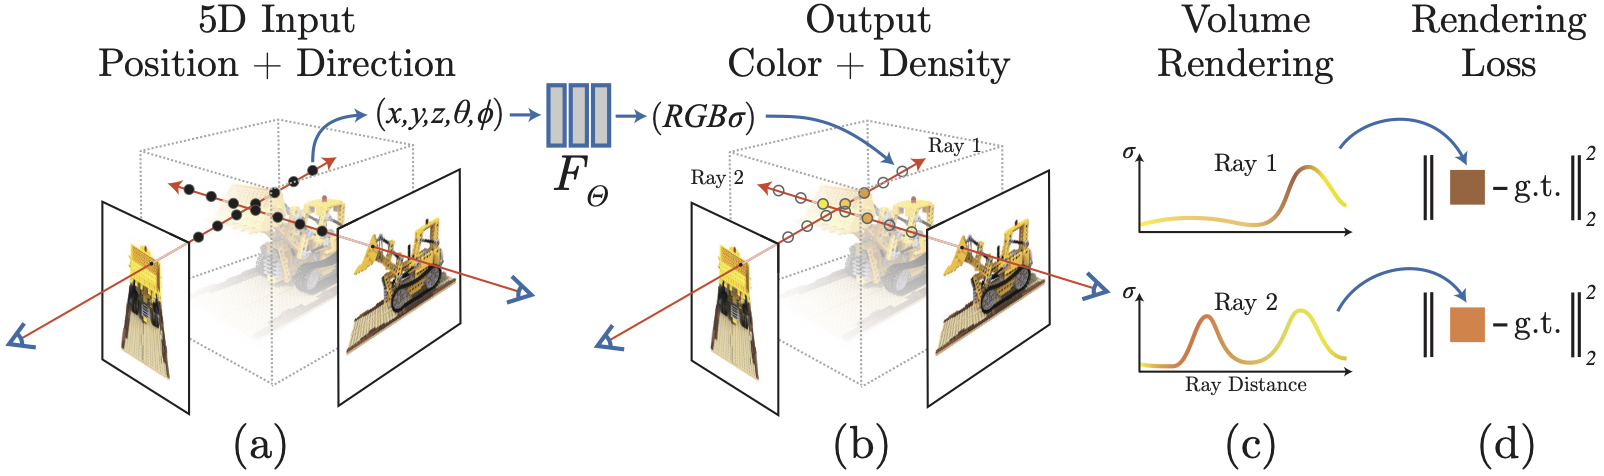

## 0.2 Pytorch Introduction

**0.2.1 Numpy and Pytorch**

Many functions from pytorch are identical to numpy's versions (except that they output tensors instead of arrays). Try it out on linspace. (Hint: Use torch.linspace)

In [ ]:
def student_linspace(start, end, num):
    return torch.linspace(0,1,4)

print(np.linspace(0,1,4))
print(student_linspace(0,1,4))

[0.         0.33333333 0.66666667 1.        ]
tensor([0.0000, 0.3333, 0.6667, 1.0000])


One function you should know is torch.from_numpy(). This will convert a numpy array into a torch tensor.

In [ ]:
def student_tensor(t):
    return torch.from_numpy(t)

print(np.array([1,2,3]))
print(student_tensor(np.array([1,2,3])))

[1 2 3]
tensor([1, 2, 3])


**0.2.2 Indexing**

A key component of both numpy and pytorch are high-dimensional tensors and specifically indexing into them. As an example, lets look at a HxWx3 tensor representing an image. We'll start by loading in an image.


torch.Size([300, 300, 3])

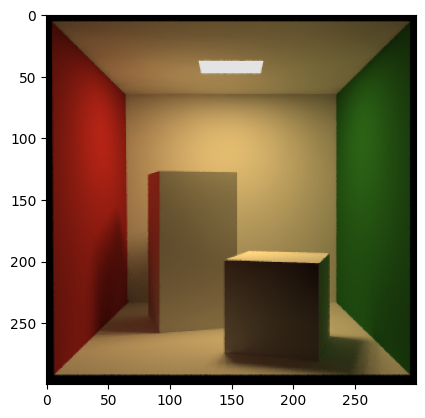

In [ ]:
image = transforms.functional.pil_to_tensor(Image.open("sol/cornell_box.png")).permute((1,2,0))
plt.imshow(image)
image.shape

The 3 in the shape refers to the 3 different RGB channels of the image. What if we want to get only the R channel? To do this, we can use indexing syntax like shown below. We have 3 things inside the brackets because our original tensor has 3 dimensions. If we put ":" for a dimension, that means we want everything in that dimension, and if we put a number of range of numbers, that means we want that range.

To get R, we want everything in the height and width dimensions but only the first value in the color dimension:

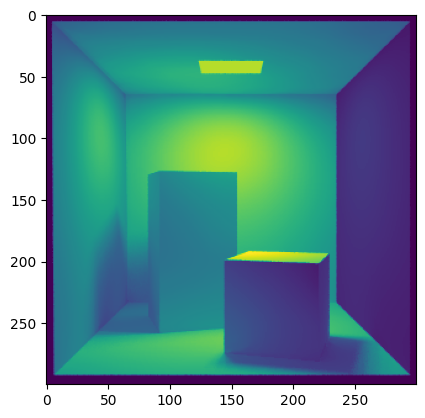

In [ ]:
red = image[:,:,0]
plt.imshow(red)

What if instead we wanted the top left 100x100 corner in all 3 colors? How would you do that?

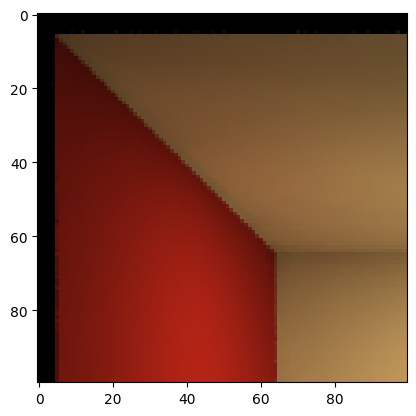

In [ ]:
top_left = image[:100,:100,:]
plt.imshow(top_left)

If you want to add a dimension to a tensor, you can use ".unsqueeze(dim)" and the corresponding ".squeeze(dim)" to undo it. An example:

In [ ]:
test_tensor = torch.zeros((4,4))
print(f"Shape at start: {test_tensor.shape}")

test_tensor = test_tensor.unsqueeze(2)
print(f"Shape after unsqueeze: {test_tensor.shape}")

test_tensor = test_tensor.squeeze(2) # What happens if I try to squeeze out dim 0 or 1 instead?
print(f"Shape after squeeze: {test_tensor.shape}")

Shape at start: torch.Size([4, 4])
Shape after unsqueeze: torch.Size([4, 4, 1])
Shape after squeeze: torch.Size([4, 4])


You can also index using another array, either an integer or boolean array:

In [ ]:
x = torch.arange(10) - 5
select_idx = torch.tensor([0,2,5,6,8])
print(f"X: {x}")
print(f"selected: {x[select_idx]}")

select_idx = (x > 0)
print(f"selected positive only: {x[select_idx]}")

X: tensor([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])
selected: tensor([-5, -3,  0,  1,  3])
selected positive only: tensor([1, 2, 3, 4])


Another key function in torch/numpy is to combine multiple arrays in different ways (both mathematical and not).

To do mathematical operations, our arrays must have the same shape or have a shape that can be adapted to match. As an example:

In [ ]:
x = torch.zeros((2,2,2))
y = torch.ones((2,2,2))

print(f"X: {x}")
print(f"Y: {y}")
print(f"X+Y: {x+y}")

z = torch.ones((2,2,1))
print(f"X+Z: {x+z}") # Torch will convert the "1" in dimension 2 to "2" automatically

t = torch.ones((2,2))
print(f"X+T: {x+t}") # Torch will add the extra dimension for you and duplicate

r = torch.ones((3,3))
try:
    print(f"X+R: {x+r}") # Wont work
except:
    print("X+R: Didn't work")

X: tensor([[[0., 0.],
         [0., 0.]],

        [[0., 0.],
         [0., 0.]]])
Y: tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])
X+Y: tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])
X+Z: tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])
X+T: tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])
X+R: Didn't work


We may also want to combine matrices into larger matrices:

In [ ]:
x = torch.zeros((2,2))
y = torch.ones((2,2))

z = torch.stack([x,y])
t = torch.cat([x,y])
t2 = torch.cat([x,y], dim=1)

print(f"X: {x}, shape: {x.shape}")
print(f"Y: {y}, shape: {y.shape}")
print(f"Z: {z}, shape: {z.shape}")
print(f"T: {t}, shape: {t.shape}")
print(f"T2: {t2}, shape: {t2.shape}")

X: tensor([[0., 0.],
        [0., 0.]]), shape: torch.Size([2, 2])
Y: tensor([[1., 1.],
        [1., 1.]]), shape: torch.Size([2, 2])
Z: tensor([[[0., 0.],
         [0., 0.]],

        [[1., 1.],
         [1., 1.]]]), shape: torch.Size([2, 2, 2])
T: tensor([[0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.]]), shape: torch.Size([4, 2])
T2: tensor([[0., 0., 1., 1.],
        [0., 0., 1., 1.]]), shape: torch.Size([2, 4])


**0.2.3 Meshgrid**

torch.meshgrid() is a useful function you will need when implementing NeRF. Intuitively, this function takes two ranges of numbers and then creates a 2D grid of all combinations of both ranges.

To test this, lets visualize two ranges:

If you want the x and y values of a HxW, use this function.

Note: There are two ways to index: "xy" and "ij". Try changing the indexing of the example and see how that affects your outputs. To learn more about meshgrid, you can read the following article: https://www.geeksforgeeks.org/numpy-meshgrid-function/

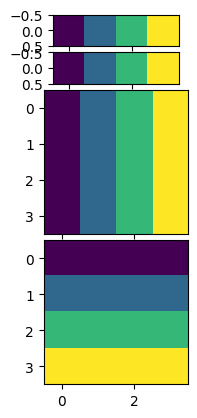

In [ ]:
x = torch.tensor([1,2,3,4])
y = torch.tensor([1,2,3,4])

xx, yy = torch.meshgrid(x, y, indexing='xy')

fig, ax = plt.subplot_mosaic("""
                             AAAA
                             BBBB
                             CCCC
                             CCCC
                             CCCC
                             CCCC
                             DDDD
                             DDDD
                             DDDD
                             DDDD
                             """)

ax['A'].imshow(x.unsqueeze(0))
ax['B'].imshow(y.unsqueeze(0))
ax['C'].imshow(xx)
ax['D'].imshow(yy)
plt.show()

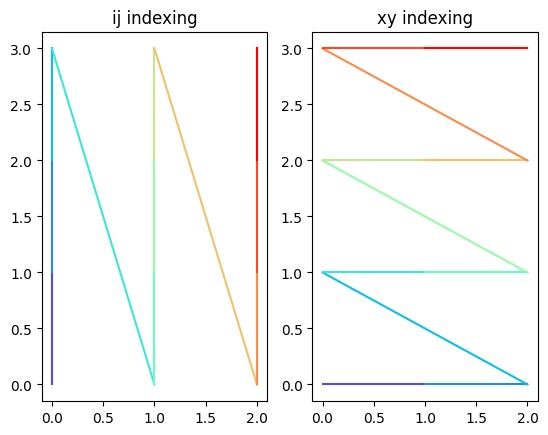

In [ ]:
def example_meshgrid(H,W, indexing):
    return torch.meshgrid(torch.arange(H), torch.arange(W), indexing=indexing)

fig, ax = plt.subplots(1,2)

x, y = example_meshgrid(3,4, indexing='ij')
x, y = x.flatten(), y.flatten()
# Create a colormap
colors = cm.rainbow(np.linspace(0, 1, len(x)))
ax[0].set_title('ij indexing')
for i in range(1, len(x)):
    ax[0].plot(x[i-1:i+1], y[i-1:i+1], color=colors[i])

x, y = example_meshgrid(3,4, indexing='xy')
x, y = x.flatten(), y.flatten()
ax[1].set_title('xy indexing')
for i in range(1, len(x)):
    ax[1].plot(x[i-1:i+1], y[i-1:i+1], color=colors[i])

plt.show()

As shown above, 'ij' indexing goes column by column, but 'xy' indexing goes row by row.

**0.2.3 Cumulative Product**

torch.cumprod() is another useful function you will need when implementing NeRF. Consider you have a tensor of values. This function will create a tensor whose ith value is the product of all elements before and including the ith value.

However, you will need a modified version of this function that allows the "exclusive" parameter. If this parameter is True, the output is a tensor whose ith value is the product of all elements before but NOT including the ith value.

In [ ]:
def student_cumprod(t, exclusive=False):
    if exclusive:
      non_exclusive_cumprod = torch.cumprod(t.clone(), dim = -1)
      first_col = non_exclusive_cumprod[..., -1:]
      other_columns = non_exclusive_cumprod[..., :-1]
      cumprod = torch.cat((first_col, other_columns), dim=-1)
      cumprod[..., 0] = 1
    else:
      cumprod = torch.cumprod(t, dim = -1)
    return cumprod

print("Input:", torch.tensor([1.5,2,3,4]))
print("Cumprod, inclusive:", student_cumprod(torch.tensor([1.5,2,3,4])))
print("Cumprod, exclusive:",student_cumprod(torch.tensor([1.5,2,3,4]), exclusive=True))

Input: tensor([1.5000, 2.0000, 3.0000, 4.0000])
Cumprod, inclusive: tensor([ 1.5000,  3.0000,  9.0000, 36.0000])
Cumprod, exclusive: tensor([1.0000, 1.5000, 3.0000, 9.0000])


# 1 Computing and Rendering Rays

In this secton, please use pytorch instead of numpy. As we will be training a neural network, it will be easier to integrate your code instead of swapping between the two domains.

## 1.1 From Pixels to World Rays

**1.1.1 Creating ray directions from pixels**

Imagine rays being ejected from the camera to pierce each pixel in an image. The rays would start from the middle point of the sensor and hit the lens (where the image is). Each ray is being ejected from the camera, so they all point away in equal amounts in the z-direction. This means that the rays passing through the middle of the image are almost all (or exactly all) in the z-direction. Compute the directions of the rays for every pixel in the image.

Take a look at the figure below and try to derive the 3D position of a pixel in camera space.

Hint: The z component of all the rays are -1.

Hint: Imagine the line pointing from the camera center to one of the sides. What is the direction and length of the x and y components of the ray? Now consider a slightly smaller pyramid (one pixel removed from around the image). What is the direction and length of the x and y compenents of this new rays? How can we generalie this to get the x and y components of any ray in the image?

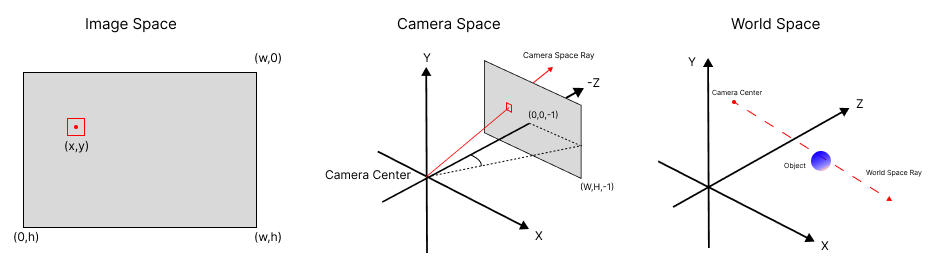

In [ ]:
def student_compute_ray_directions(i,j,H,W,focal):
    """
    Compute ray directions given an image size and field of view.

    Parameters:
    - i (torch.Tensor, [H,W]): x index of pixels
    - j (torch.Tensor, [H,W]): y index of pixels
    - H (int): Height of the image (or viewport).
    - W (int): Width of the image (or viewport).
    - focal (float): The focal length of the camera.

    Returns:
    - dirs (torch.Tensor): Directions (x,y,z) of the rays for every pixel in the image. [H,W,3]
    """

    # Transform coordinates so that 0,0 is on the center of the screen and normalize by dividing with focal length
    dirs = torch.stack([(i-W/2)/focal, (H/2-j)/focal, -1*torch.ones(i.shape)], dim=-1)
    return dirs

**1.1.2 Compute World Rays**

The directions and positions of rays we imagined in the last part are with respect to the camera. To get data that is generalizable and compatible to other camera positions and angles, we need to convert the rays from the camera's space to the world's space.


The c2w matrix is composed of a rotation matrix and a translation vector. The rotation matrix describes how to convert a ray from the camera's coordinate system to a generalizable coordinate system. The translation vector describes the camera's position in a generalizable space. Thus, the c2w matrix is unique to each pose an image is taken in. The c2w matrix is of shape 4x4. The c2w matrix is stored in the following way:

$$[R, t]$$

Using the above information, compute rays_o -- a matrix containing the origins of each ray in the world's space -- and rays_d -- a matrix containing the direction of each ray in the world's space.

In [ ]:
def student_compute_world_rays(dirs,c2w):
    """
    Convert the rays from camera space to world space.

    Parameters:
    - dirs (torch.Tensor, [H,W]): Directions of the rays for every pixel in the image.
    - c2w (torch.Tensor, [3,4]): A 3x4 camera-to-world transformation matrix.

    Returns:
    - rays_o (torch.Tensor, [H,W,3]): Origins of the rays in world space for every pixel in the image
    - rays_d (torch.Tensor, [H,W,3]): Directions of the rays in world space for every pixel in the image
    """

    # Multiply directions with the camera to world rotation matrix to get the ray directions in the world corodinates
    rays_d = torch.matmul(dirs.unsqueeze(-2), c2w[:3, :3].T).squeeze(-2)
    # Expand the translation matrix which is the origin of the world rays to have the same shape as rays_d
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d

**1.1.3 get_rays Function**

Using the two previous two sections, create a function to compute a world origins and directions of rays from H, W, focal, and c2w.

In [ ]:
def student_get_rays(H,W,focal,c2w):
    """
    Generate rays given an image size, focal length, and a camera-to-world transformation matrix.

    Parameters:
    - H (int): Height of the image (or viewport).
    - W (int): Width of the image (or viewport).
    - focal (float): The focal length of the camera.
    - c2w (torch.Tensor, [3,4]): A 3x4 camera-to-world transformation matrix.

    Returns:
    - rays_o (torch.Tensor, [H,W,3]): Origins of the rays in world space for every pixel in the image [H,W,3]
    - rays_d (torch.Tensor, [H,W,3]): Directions of the rays in world space for every pixel in the image [H,W,3]
    """
    # Step 1: compute grid for x,y components
    i, j = torch.meshgrid(torch.linspace(0,W-1,W),torch.linspace(0,H-1,H), indexing='xy')

    # Step 2: For each pixel, compute ray directions
    # Note: rays always point to camera (in z direction)
    dirs = student_compute_ray_directions(i.to(dtype=torch.float32), j.to(dtype=torch.float32), H, W, focal)

    # Step 3: Compute rays_o and rays_d
    rays_o, rays_d = student_compute_world_rays(dirs, c2w)

    return rays_o, rays_d

In [ ]:
H_test = 32
W_test = 32
focal_test = 2
c2w_test = torch.eye(4)
rays_o_sol = torch.load('sol/rays_o.pt')
rays_d_sol = torch.load('sol/rays_d.pt')

res = student_get_rays(H_test, W_test,focal_test, c2w_test)
check_code_correctness(student_get_rays,H_test,W_test,focal_test,c2w_test,test_outs=[rays_o_sol,rays_d_sol])

True

## 1.2 Rendering Rays

Now that we have rays, we need to know what the colors along the rays is going to be. That will help us paint a view of the scene.

In particular, we will use a neural network that predicts the color and density of specific points. The process of us "painting" the picture will then look like this:

1.   Sample points that we want to paint/render in our scene.
2.   Use the neural network to determine the color and density at those points.
3.   Find the weights associated with the density of each position.
4.   Blend the colors using the weights to paint/render our scene.

**1.2.1 Querying Points**

Using the world rays we calculated in the last section, calculate where along the rays we should check the scene's color and density.

For each ray, we want to sample a set of linearly distanced points between the factors of 'near' and 'far'. These points are where we'll ask our neural network about the color and density of the scene.

Hint: Remember that we are sampling along multiples of the rays. Thus, each point should be the sum its rays origin as well as the direction multiplied by some factor.

In [ ]:
def student_compute_query_points(rays_o, rays_d, near, far, N_samples, rand=False):
    """
    Compute 3D query points along each ray.

    Inputs:
    - rays_o (torch.Tensor, [H,W,3]): Starting points of each ray. Think of this as where the camera is.
    - rays_d (torch.Tensor, [H,W,3]): Directions each ray is pointing towards.
    - near (float): How close to start looking along the ray.
    - far (float): How far to stop looking.
    - N_samples (int): How many points to check along each ray.
    - rand (bool): If true, jiggle the points a bit for smoother results.

    Returns:
    - pts (torch.Tensor, [H,W,N_samples,3]): 3D query points.
    - z_vals (torch.Tensor, [N_samples]): The distance along an arbitrary ray to each query point
    """

    # Create z values
    if rand:
      z_vals = torch.linspace(near,far,N_samples) + torch.rand(N_samples)*((far-near)/N_samples)
    else:
      z_vals = torch.linspace(near,far,N_samples)

    # rays can be modelled as r = o + t*d
    pts = rays_o.unsqueeze(-2) + rays_d.unsqueeze(-2)*z_vals.unsqueeze(-1)

    return pts, z_vals

**1.2.2 Feed Query Points to Network**

We will feed the 3D points we queried from the last section into our neural network. Remember, the neural network is like our painter. At each point we give it, the network will return the color and density at that point. However, our neural network cannot understand the inputs directly from the 3D coordinates. We will have to modify our inputs using a "positional encoding".

In this function, feed the points into the network and return the colors and opacities.

Hint: It can be very memory intensive to process every point at once! Thus, we have provided a "batchify" function to split up your inputs as you feed it into the network_fn.
Hint: Reshape the output to be same shape as the input but with 4 channels (rgb,and density) instead of 3 at the end.

In [ ]:
def student_query_network(network_fn, embed_fn, pts):
    """
    Ask the neural network about color and density for each point.

    Inputs:
    - network_fn (function): Our neural network.
    - embed_fn (function): The positional encoding function.
    - pts (torch.Tensor, [N_samples,3]): The points in space where we want to know about the scene's color and density.

    Returns:
    - raw (torch.Tensor, [H,W,N_samples,4]): The raw output of the neural network that returns the point's rgb and density.
    """
    pts = pts.to(device)
    def batchify(fn, chunk=1024*32):
        """Helper function to run the network in smaller batches."""
        return lambda inputs: torch.cat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # flattens pts and preprocess them
    preprocessed_pts = embed_fn(pts.view(-1, 3))
    # batchify network input
    batch_network_fn = batchify(network_fn)

    # get network inference and reshape data properly
    raw = batch_network_fn(preprocessed_pts).view(list(pts.shape[:-1])+[4])

    return raw.to("cpu")


**1.2.3 From Density to Weights**

If a spot is very foggy/opaque, it'll affect the ray's color a lot. If it's clear, not so much. We're figuring out this "weight" for each point.

Here is the overview of the function:


1.   Remove any opacities that are less than 0.
2.   Calculate the distances between each point we queried on each ray.
3.   Use the equation transparency = 1 - exp(-density * thickness)
4.   Find the weight, which is the transparency multiplied by the cumulative product of (1-transparency) of previous segments

For step 4, we want opaque segments early in the rays to contribute to the image's final color more than segments later in the rays. (Intution: Consider looking at a wall. Do you expect to see objects behind it? Does this still hold even if the objects behind the wall are very opaque?)



In [ ]:
def student_compute_weights(opacities, z_vals):
    """
    Calculate how much each point affects the ray's final color based on the point's density.

    Inputs:
    - opacities (torch.Tensor, [N_samples,1]): Information from our neural network about the scene's density at each point.
    - z_vals (torch.Tensor, [N_samples,1]): Distances along the ray where we checked the scene's color and density.

    Returns:
    - weights (torch.Tensor, [H,W,N_samples,4]): How much each point affects the ray's final color.
    """

    # Add 1e10 to the end to make up for dimension difference
    distances = torch.cat((torch.diff(z_vals), torch.tensor([1e10])), dim=0)
    # Find transparency values
    transparency = torch.ones(opacities.shape)-torch.exp(-opacities*distances)
    # Calculate the weights ( by adding 1e-10 we remove zero values)
    weights = transparency * student_cumprod(torch.ones(transparency.shape) - transparency + 1e-10, exclusive=True)

    return weights

**1.2.4 Putting it all Together**

Using the past three functions, we will paint/render our rays to produce an image. Follow the comments in the function to create our algorithm.

In [ ]:
def student_render_rays(network_fn, embedding_fn, rays_o, rays_d, near, far, N_samples, rand=False):
    """
    Shine the rays through our scene to get a picture.

    Inputs:
    - network_fn (function): Our neural network.
    - embedding_fn (function): The positional encoding function.
    - rays_o (torch.Tensor, [H,W,3]): Where each ray of light starts.
    - rays_d (torch.Tensor, [H,W,3]): The direction each ray is shining.
    - near (float): How close to start looking along the ray.
    - far (float): How far to stop looking.
    - N_samples (int): How many points to check along each ray.
    - rand (bool): If true, jiggle the points a bit for smoother results.

    Returns:
    - rgb_map (torch.Tensor, [H,W,3]): The final color of each ray.
    - depth_map (torch.Tensor, [H,W]): The final depth of each ray.
    - acc_map (torch.Tensor, [H,W]): The final transparency of each ray.
    """
    # 1. Compute 3D query points along the rays.
    pts, z_vals = student_compute_query_points(rays_o, rays_d, near, far, N_samples, rand)

    outputs = student_query_network(network_fn, embedding_fn, pts)

    # Normalize colour values using sigmoid
    colours = torch.sigmoid(outputs[...,:-1])
    # Makes opacity valeus non linear
    opacities = torch.relu(outputs[...,-1])

    weights = student_compute_weights(opacities, z_vals)

    rgb_map = torch.sum(colours * weights.unsqueeze(-1), dim=-2)
    depth_map = torch.sum(z_vals * weights, dim=-1)
    acc_map = torch.sum(weights, dim = -1)

    return rgb_map, depth_map, acc_map

In [ ]:
def network_fn_test(input):
    matrix = torch.ones((3,4))
    return input @ matrix

def embedding_fn_test(input):
    return input

device = "cpu"
rays_o_test = torch.load('sol/rays_o.pt')
rays_d_test = torch.load('sol/rays_d.pt')
near_test = 0.5
far_test = 10.
N_samples_test = 64
rand_test = False
rgb_sol = torch.load('sol/rgb_map.pt')
depth_sol = torch.load('sol/depth_map.pt')
acc_sol = torch.load('sol/acc_map.pt')

student_render_rays(network_fn_test,embedding_fn_test, rays_o_test,rays_d_test,near_test,far_test, N_samples_test,rand_test)
check_code_correctness(student_render_rays,network_fn_test,embedding_fn_test,\
                       rays_o_test,rays_d_test,near_test,far_test,\
                       N_samples_test,rand_test,test_outs=[rgb_sol,depth_sol,\
                       acc_sol])

True

# 2 The Neural Network: Our Magic Ray Painter

The Neural Network of NeRF is very simple. It is just a few linear layers and ReLU with skip connections. You will implement the neural network portion in this section. We will provide the training code. However, you are encouraged to modify the architecture, as we give you full points as long as you reach 22 PSNR with positional encoding.

Here is the architecture of NeRF's simple model:

*   8 intermediate layers w/ ReLU's after each
*   Intermediate layers have a width of 256
*   4 output channels
*   Skip connections every 4 layers (Input is fed into this layer as well as the previous layer's output)
*   Input is [..., 3+3$*$2$*$L] (L is the dimensional expansion from the encoding function)

Note: To read more about building up a Neural Network, read the following article: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html



**2.1.1 Create your NeRF Model**

In [ ]:
class student_NeRF_Model(nn.Module):
    def __init__(self, D=8, W=256, output_ch=4, skip=4, L=6):
        """
        NeRF's model.

        Input:
        D: number of layers for density
        W: number of hidden units in each layer
        skip: int that represents which layers have residuals concatenated to inputs
        L: size of positional encoding dimension
        """
        super().__init__()
        self.D = D
        self.W = W
        self.input_ch = 3 + 3*2*L
        self.output_ch = output_ch
        self.skip = skip

        layers = []

        # Input layer
        layers.append(nn.Linear(self.input_ch, W))

        # Intermediate layers with skip connection
        for i, layer in enumerate(range(self.D)):
          if i % 4 == 0:
            layers.append(nn.Linear(self.W + self.input_ch, self.W))
            layers.append(nn.ReLU())
          else:
            layers.append(nn.Linear(self.W, self.W))
            layers.append(nn.ReLU())


        # Output layer
        layers.append(nn.Linear(self.W,self.output_ch))

        self.model = nn.ModuleList(layers)

    def forward(self, x):
        """
        Inputs:
        x: query inputs [B, 3+(3*2*L)] <- (The second dim is from positional_encoding)

        Outputs:
        raws: raw outputs from model containing rgb and density for each queried point [B, 4]
        """
        x_in = x

        # input
        x = self.model[0](x)
        # Apply intermediate layers with skip connections
        for i, layer in enumerate(self.model[1:-1]):
            if i % (4*2) == 0:
              # Skip connection *2 is to take into account relu layers in between the dense layers
              x = torch.cat([x, x_in], dim=-1)
            x = layer(x)

        # Output layer
        raws = self.model[-1](x)


        return raws

**2.1.2 Training w/o Positional Encoding**

Here, you will train without positional encoding. Your model should not perform that well, as it is missing information provided by the positional encoding.

In [ ]:
def no_positional_encoding(x, L=6):
    """
    Apply positional encoding to the input.

    Input:
    x: input coordinates [B,3]
    L: number of layers

    Output:
    pos_enc: Positional encoding of shape [B,3+(3*2*L)]
    """
    return x.repeat(1,13)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

train_images = np.concatenate([images[:101], images[102:]], axis=0)
train_poses = np.concatenate([poses[:101], poses[102:]], axis=0)
test_image = images[101]
test_pose = poses[101]

images_tensor = torch.from_numpy(train_images)
poses_tensor = torch.from_numpy(train_poses)
test_image = torch.from_numpy(test_image)
test_pose = torch.from_numpy(test_pose)

print(images_tensor.shape)
print(poses_tensor.shape)
print(test_image.shape)
print(test_pose.shape)

--2023-12-09 04:42:57--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-12-09 04:42:57--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  17.8MB/s    in 0.7s    

2023-12-09 04:42:58 (17.8 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]

torch.Size([105, 100, 100, 3])
torch.Size([105, 4, 4])
torch.Size([100, 100, 3])
torch.Size([4, 4])


In [ ]:
# Choose cuda if you have a gpu
# device = "cpu"
device = "cuda:0"

print(student_NeRF_Model())
NeRF = student_NeRF_Model().to(device)
optimizer = torch.optim.Adam(NeRF.parameters(), lr=8e-4)

N_iters = 500
psnrs = []
iternums = []
i_plot = 25
# Set this lower if you get Cuda OOM
N_samples = 64

from time import time

for i in range(N_iters):
    optimizer.zero_grad()
    idx = np.random.randint(0, train_images.shape[0])
    img = images_tensor[idx]
    pose = poses_tensor[idx]
    H = img.shape[0]
    W = img.shape[1]
    rays_o, rays_d = student_get_rays(H, W, focal, pose)
    rgb, depth, acc = student_render_rays(NeRF, no_positional_encoding, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
    loss = torch.mean((rgb - img)**2)
    loss.backward()
    optimizer.step()
    if i%i_plot == 0:
        H = test_image.shape[0]
        W = test_image.shape[1]
        rays_o, rays_d = student_get_rays(H, W, focal, test_pose)
        rgb, depth, acc = student_render_rays(NeRF, no_positional_encoding, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = F.mse_loss(rgb, test_image)

        print(f'Iteration: {i}, Loss: {loss.item()}')
        psnr = -10. * torch.math.log(loss) / torch.math.log(10.)

        psnrs.append(psnr)
        iternums.append(i)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

**2.1.3 Training w/ Positional Encoding**

Here, you will train with positional encoding. You should do much better than the model without positional encoding. You are required to reach at least 22 PSNR while validating this model.

In [ ]:
def positional_encoding(x, L=6):
    """
    Apply positional encoding to the input.

    Input:
    x: input coordinates [B,3]
    L: number of layers

    Output:
    pos_enc: Positional encoding of shape [B,3+(3*2*L)]
    """
    pos_enc = [x]
    for i in range(L):
        for fn in [torch.sin, torch.cos]:
            pos_enc.append(fn(2.**i * x))
    return torch.cat(pos_enc, dim=-1)

Iteration: 0, Loss: 0.19001896679401398


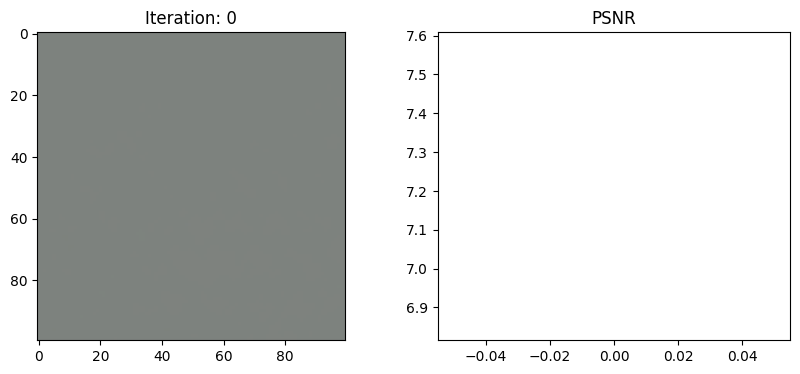

Iteration: 25, Loss: 0.08464754372835159


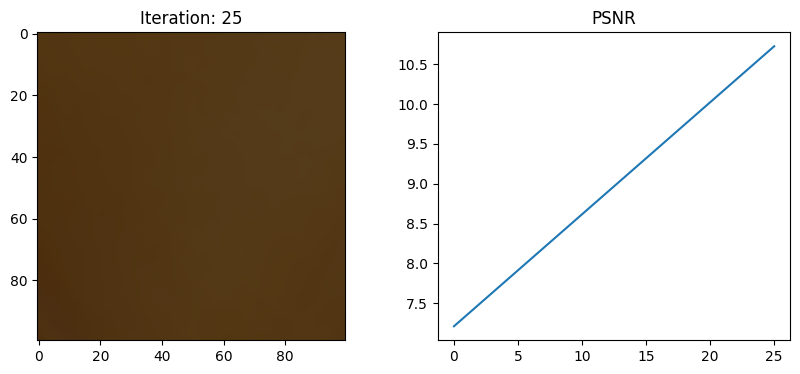

Iteration: 50, Loss: 0.07991598546504974


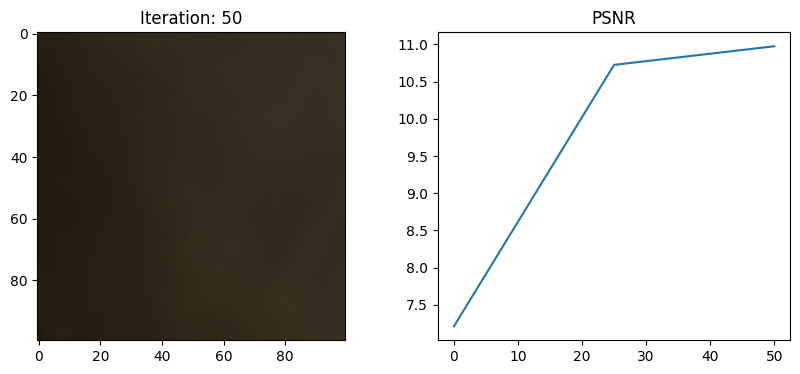

Iteration: 75, Loss: 0.07793853431940079


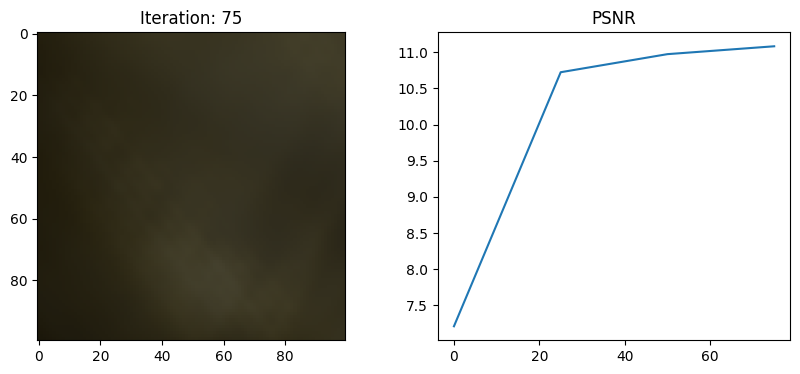

Iteration: 100, Loss: 0.06755520403385162


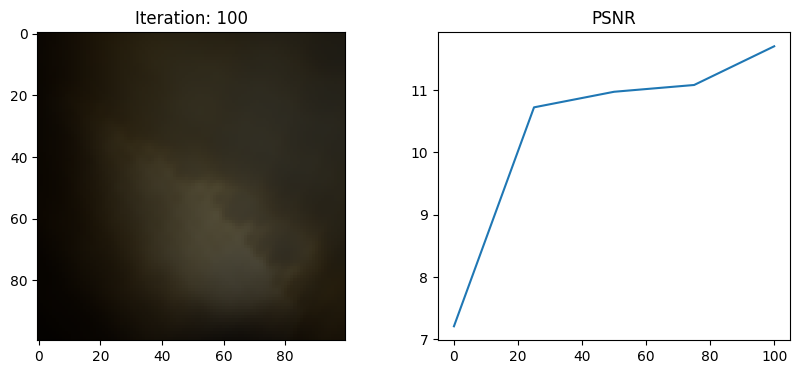

Iteration: 125, Loss: 0.06381145864725113


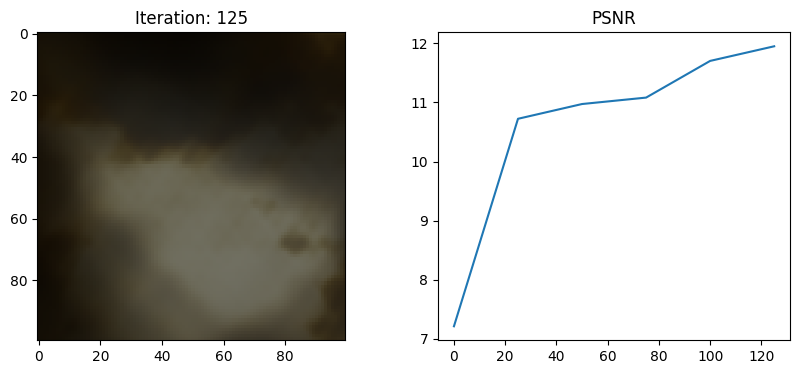

Iteration: 150, Loss: 0.04473532736301422


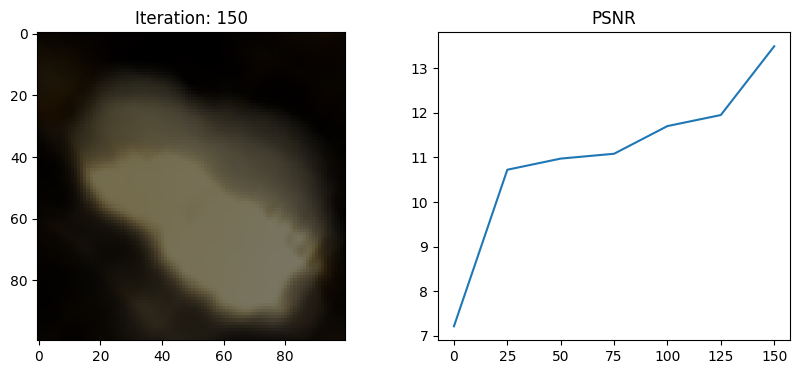

Iteration: 175, Loss: 0.04184449091553688


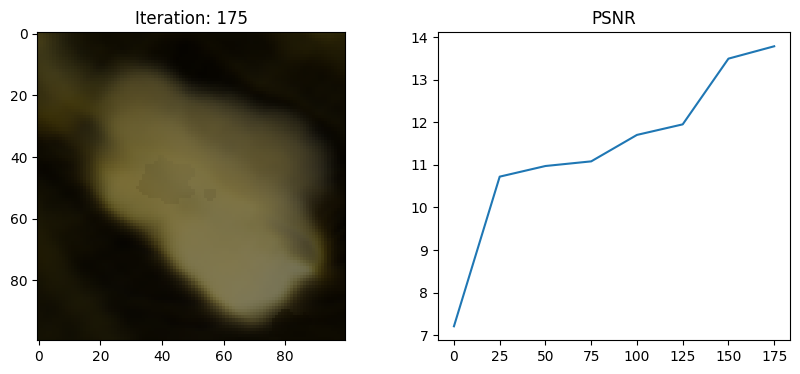

Iteration: 200, Loss: 0.027052799239754677


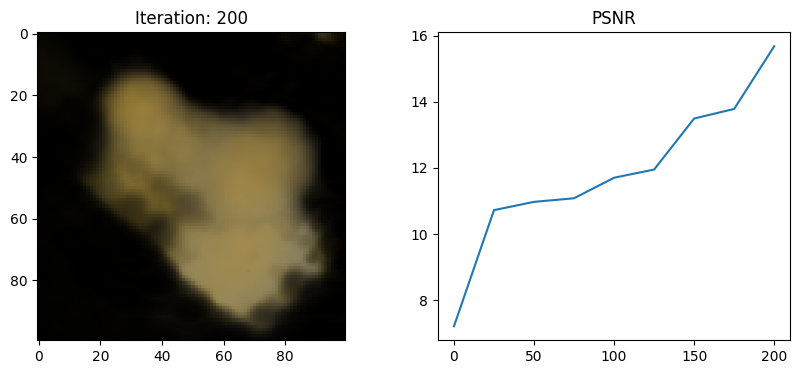

Iteration: 225, Loss: 0.022789398208260536


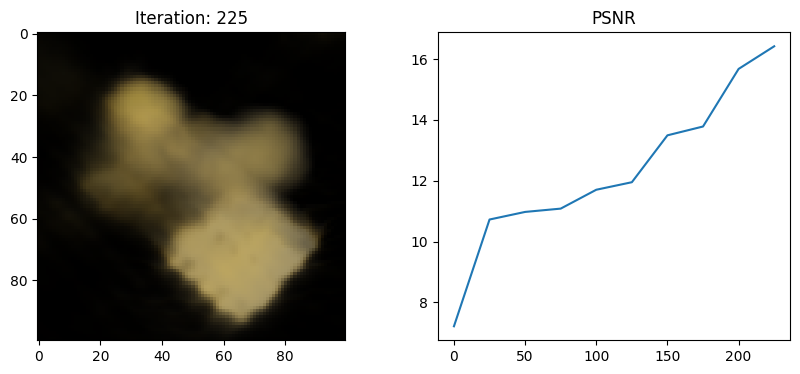

Iteration: 250, Loss: 0.02375458925962448


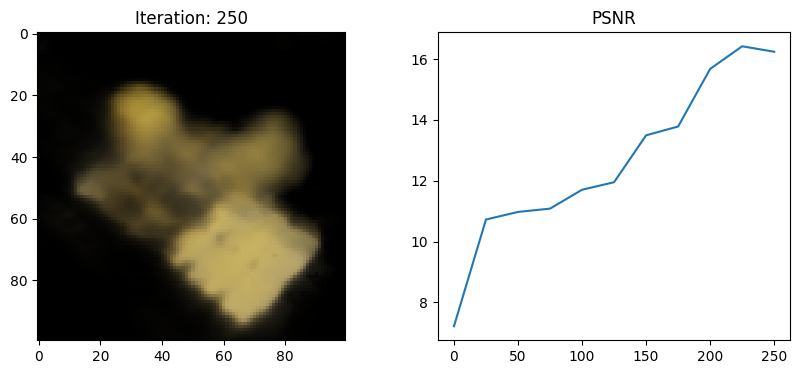

Iteration: 275, Loss: 0.017980191856622696


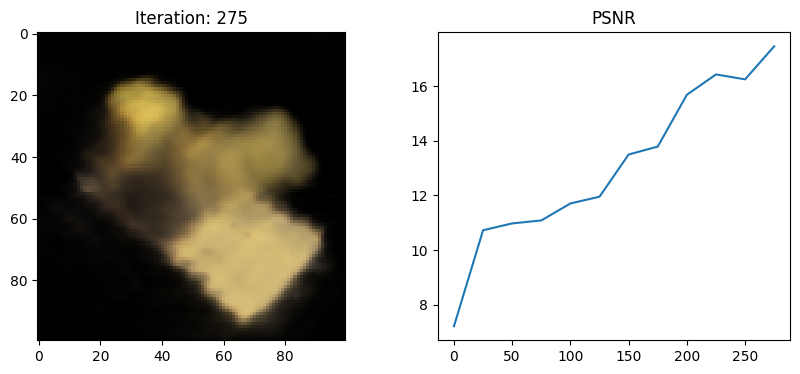

Iteration: 300, Loss: 0.015541869215667248


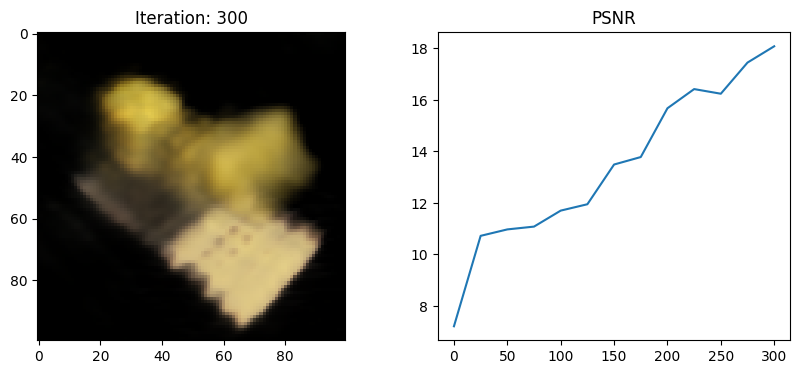

Iteration: 325, Loss: 0.018084248527884483


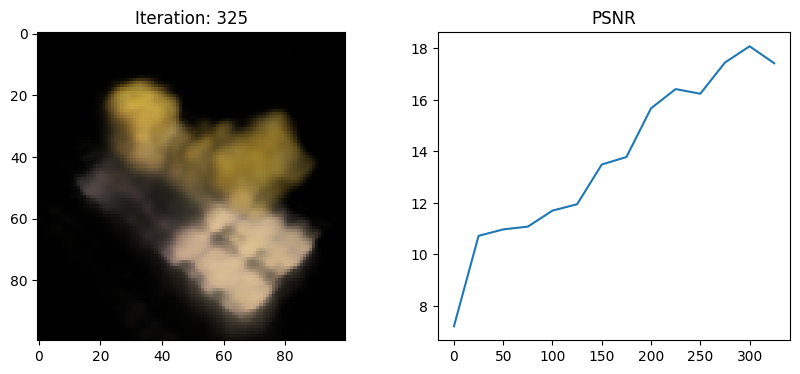

Iteration: 350, Loss: 0.014430073089897633


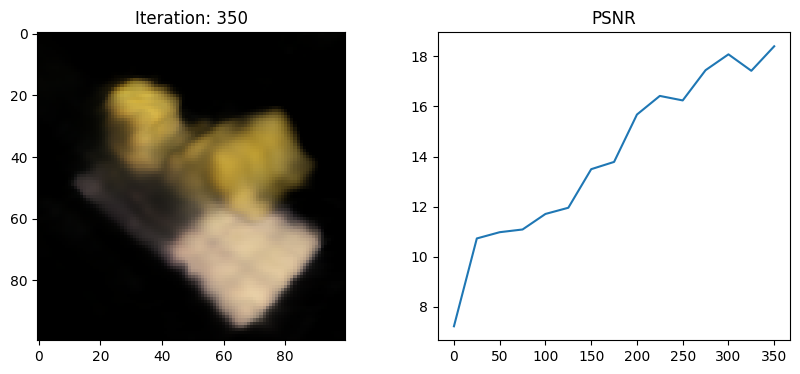

Iteration: 375, Loss: 0.01121518574655056


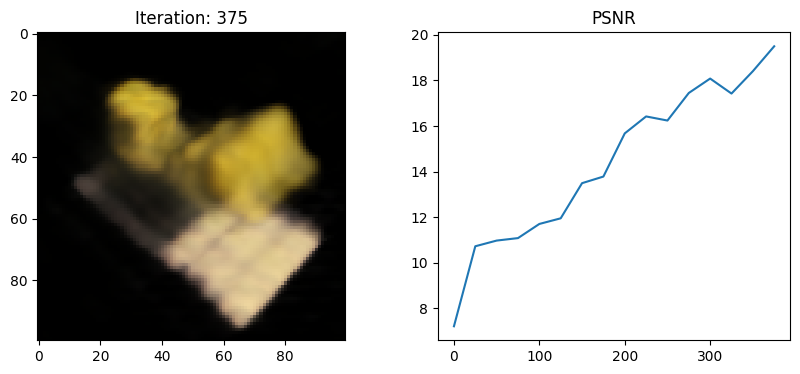

Iteration: 400, Loss: 0.009911725297570229


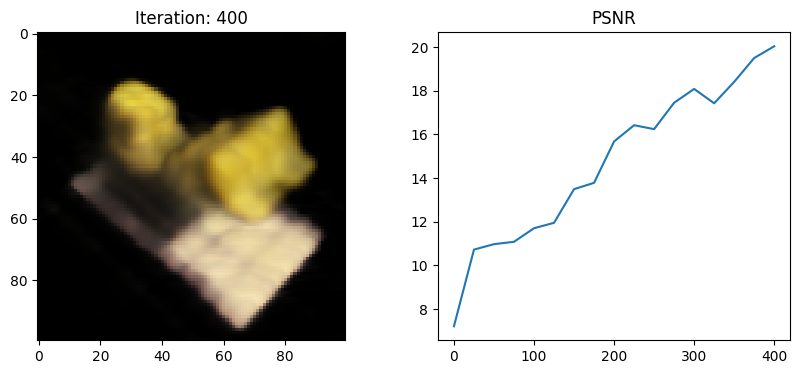

Iteration: 425, Loss: 0.0101480633020401


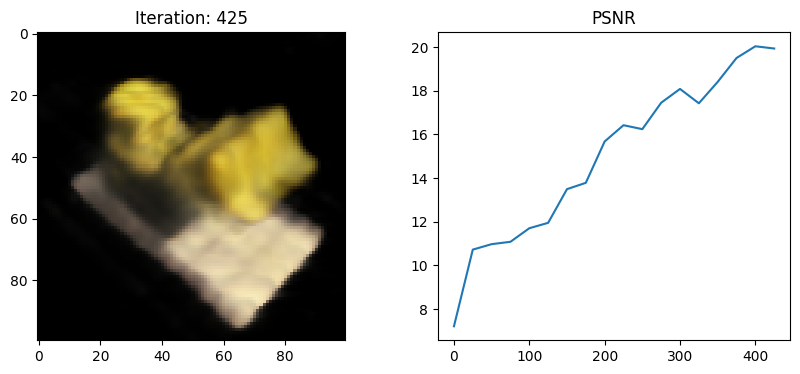

Iteration: 450, Loss: 0.009594631381332874


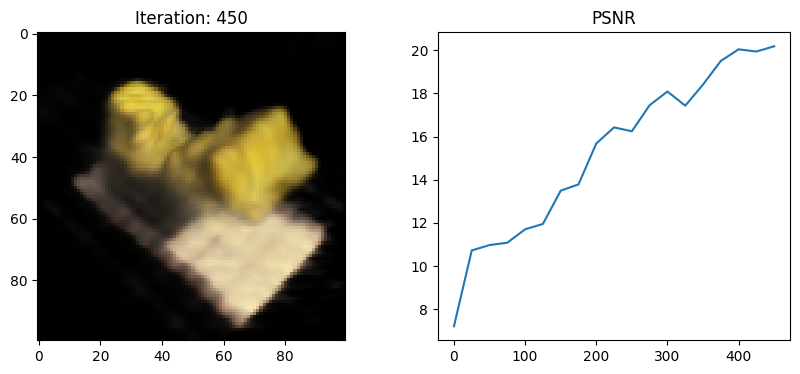

Iteration: 475, Loss: 0.009265518747270107


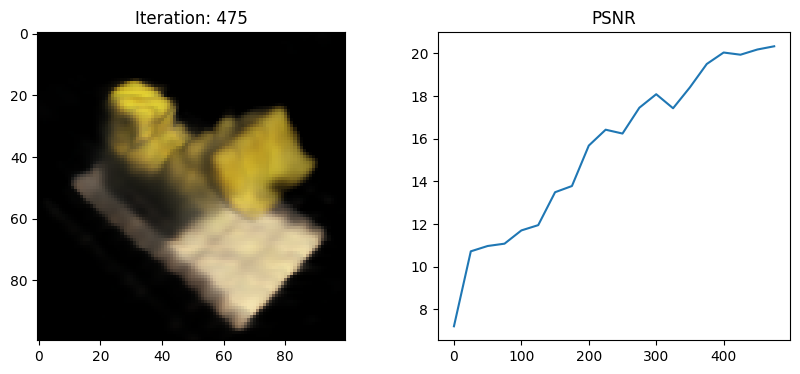

Iteration: 500, Loss: 0.008524137549102306


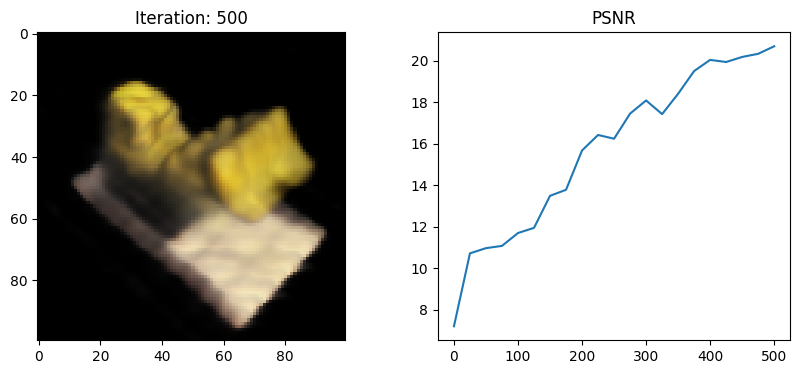

Iteration: 525, Loss: 0.009638401679694653


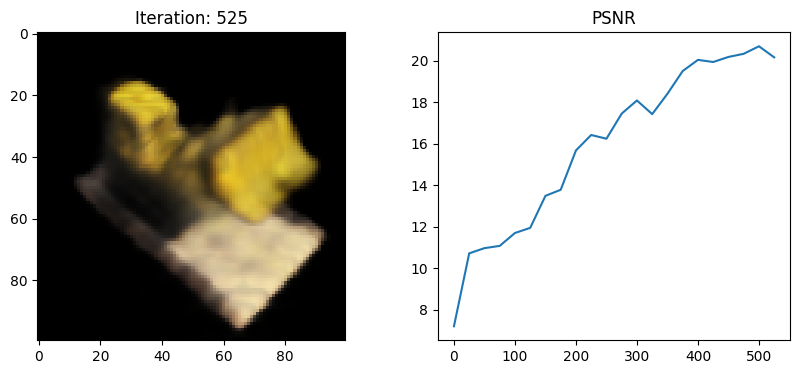

Iteration: 550, Loss: 0.00974762812256813


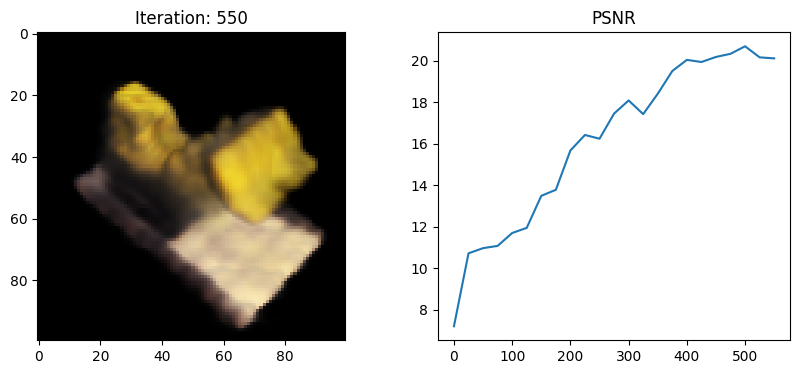

Iteration: 575, Loss: 0.0083508575335145


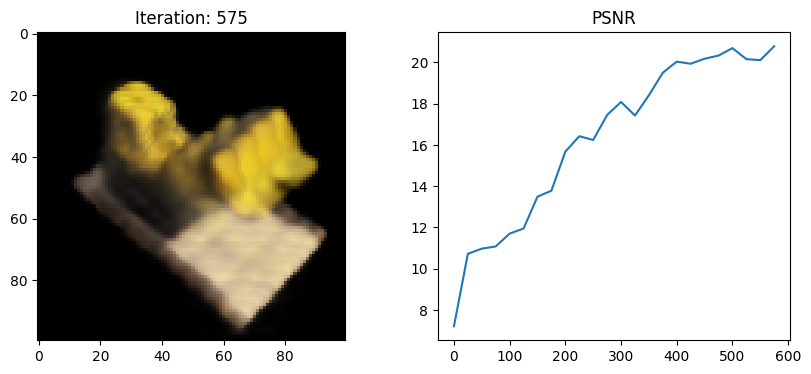

Iteration: 600, Loss: 0.008338007144629955


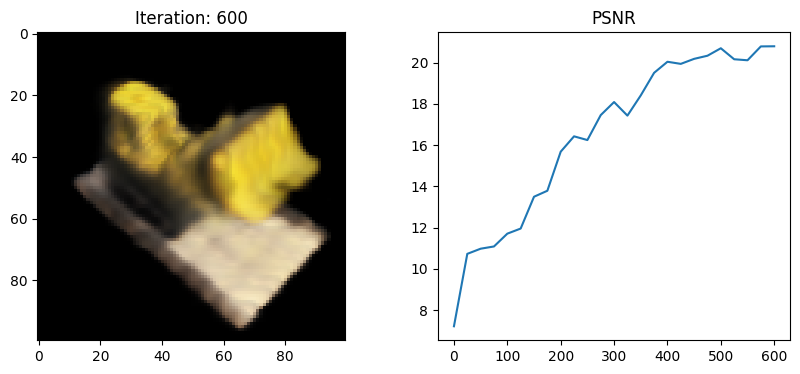

Iteration: 625, Loss: 0.008126636035740376


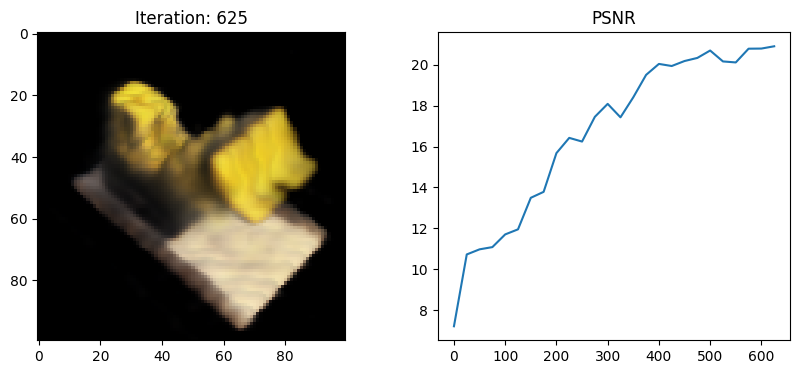

Iteration: 650, Loss: 0.008027700707316399


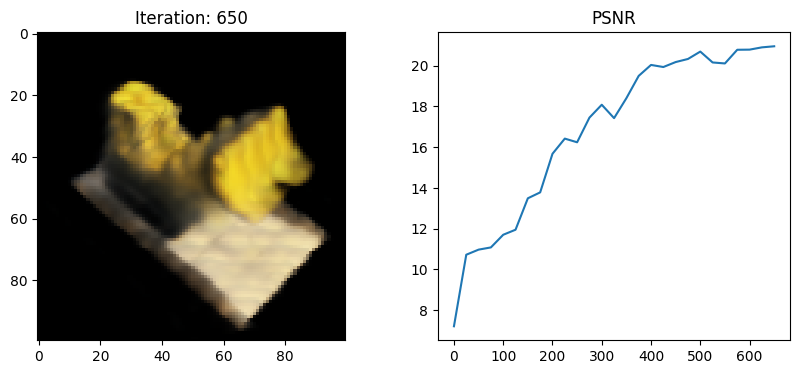

Iteration: 675, Loss: 0.0079327542334795


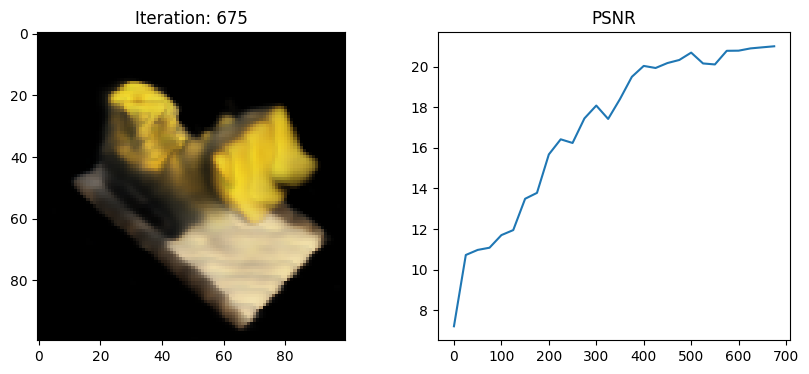

Iteration: 700, Loss: 0.007511606439948082


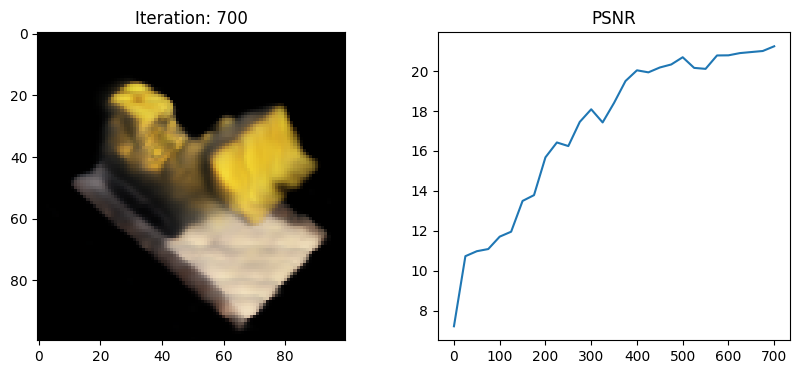

Iteration: 725, Loss: 0.007061236537992954


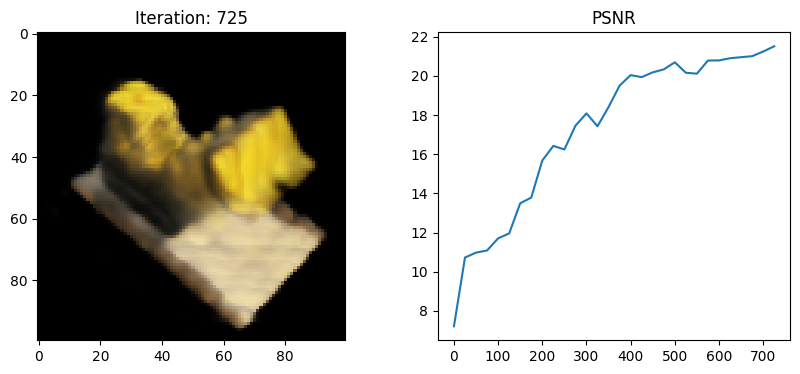

Iteration: 750, Loss: 0.007008275482803583


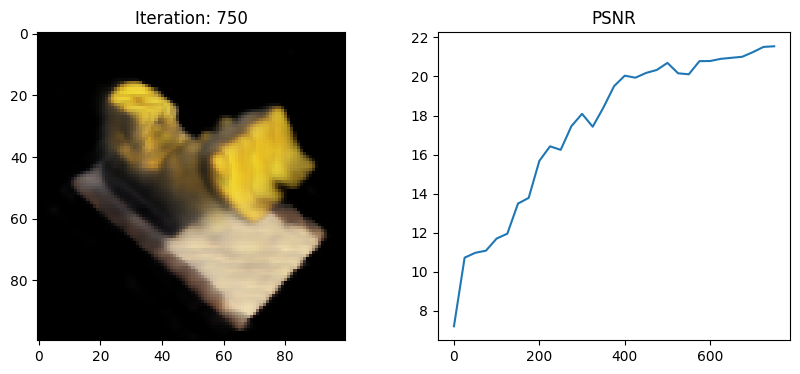

Iteration: 775, Loss: 0.007432487327605486


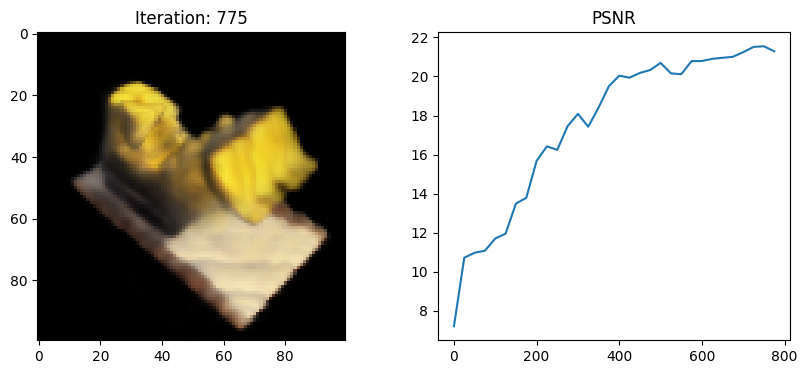

Iteration: 800, Loss: 0.007183207664638758


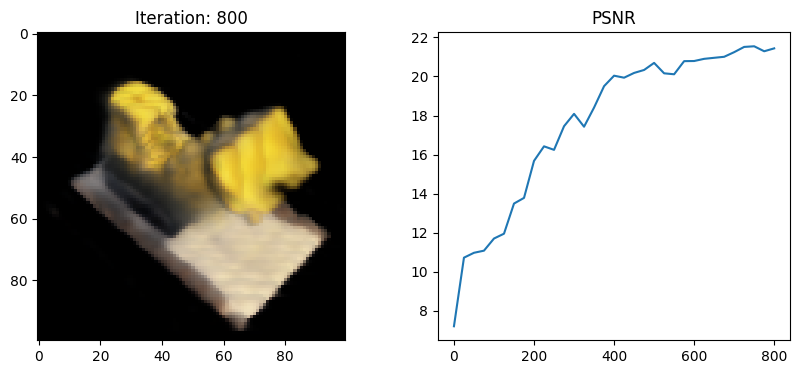

Iteration: 825, Loss: 0.006829820107668638


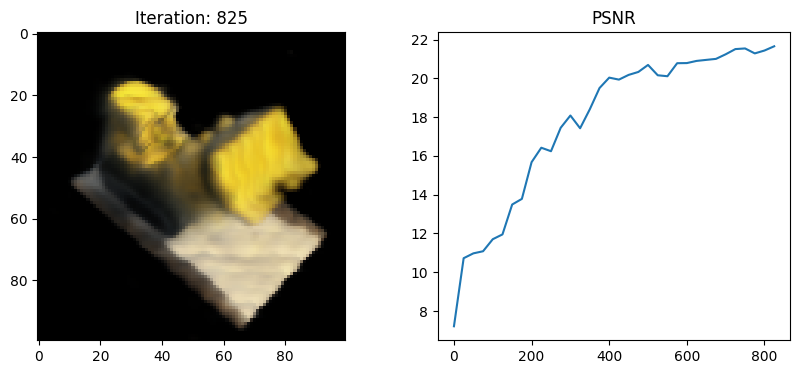

Iteration: 850, Loss: 0.006704097148030996


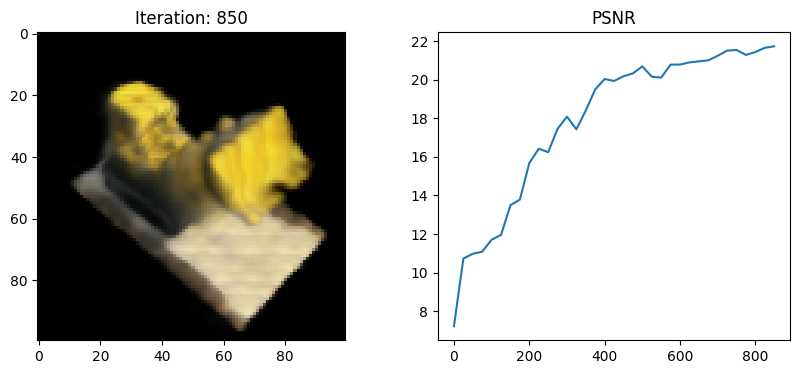

Iteration: 875, Loss: 0.007454403210431337


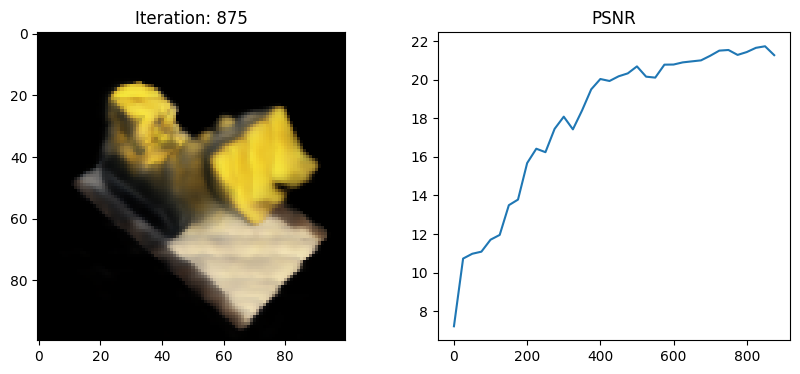

Iteration: 900, Loss: 0.006289411336183548


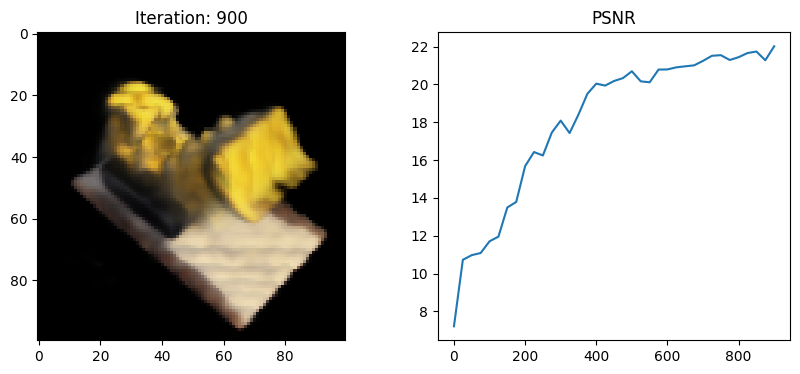

Iteration: 925, Loss: 0.006403234321624041


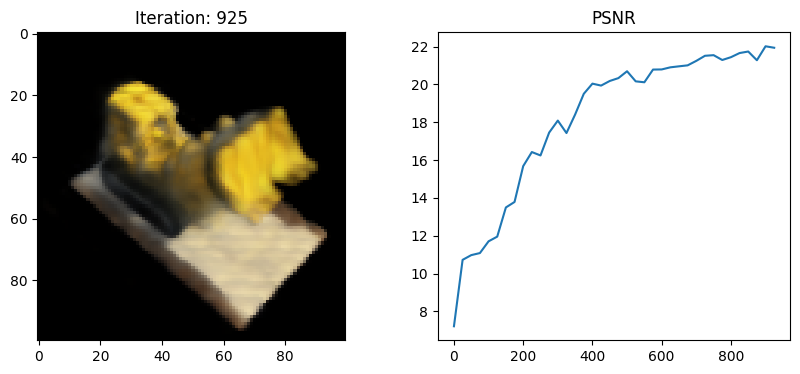

Iteration: 950, Loss: 0.006014212034642696


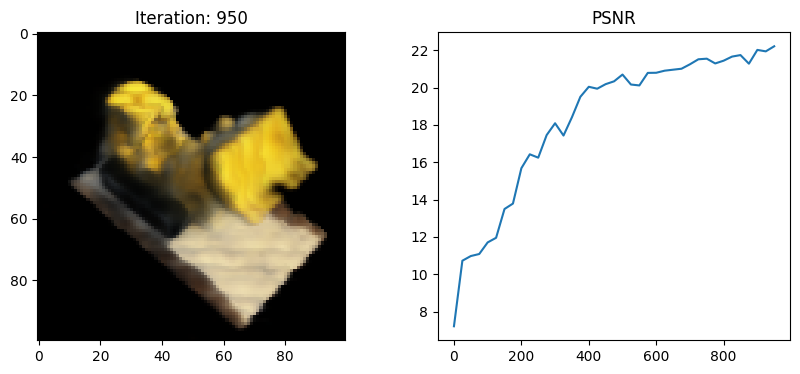

Iteration: 975, Loss: 0.006571596954017878


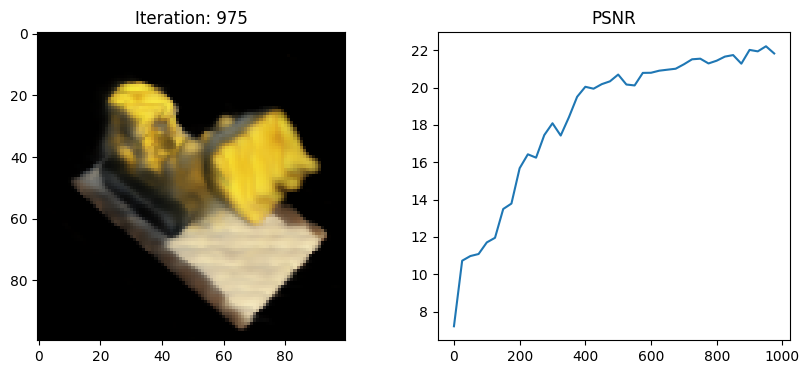

Model reached 22 PSNR!


In [ ]:
# Choose cuda if you have a gpu
# device = "cpu"
device = "cuda:0"

NeRF = student_NeRF_Model().to(device)
optimizer = torch.optim.Adam(NeRF.parameters(), lr=8e-4)

N_iters = 1000
psnrs = []
iternums = []
i_plot = 25
# Set this lower if you get Cuda OOM
N_samples = 64
threshold_reached = False

from time import time
np.random.seed(42)
torch.manual_seed(42)
for i in range(N_iters):
    optimizer.zero_grad()
    idx = np.random.randint(0, train_images.shape[0])
    img = images_tensor[idx]
    pose = poses_tensor[idx]
    H = img.shape[0]
    W = img.shape[1]
    rays_o, rays_d = student_get_rays(H, W, focal, pose)
    rgb, depth, acc = student_render_rays(NeRF, positional_encoding, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
    loss = torch.mean((rgb - img)**2)
    loss.backward()
    optimizer.step()
    if i%i_plot == 0:
        H = test_image.shape[0]
        W = test_image.shape[1]
        rays_o, rays_d = student_get_rays(H, W, focal, test_pose)
        rgb, depth, acc = student_render_rays(NeRF, positional_encoding, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = F.mse_loss(rgb, test_image)

        print(f'Iteration: {i}, Loss: {loss.item()}')
        psnr = -10. * torch.math.log(loss) / torch.math.log(10.)
        if psnr > 22.0:
            threshold_reached =  True

        psnrs.append(psnr)
        iternums.append(i)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb.detach().cpu().numpy())
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

if threshold_reached:
    print('Model reached 22 PSNR!')
else:
    print('Model did not reach 22 PSNR')

**2.2.1 The Fruits of our Work**

Now that we have a well performing model, we can create a demo that can take in any camera position and produce the resulting scene. Great work!

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = student_get_rays(H, W, focal, c2w[:3,:4])
    with torch.no_grad():
        rgb, depth, acc = student_render_rays(NeRF, positional_encoding, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 2.5, 7.5]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
# Creates a video of a 360 view generated around the scene

frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = student_get_rays(H, W, focal, c2w[:3,:4])
    with torch.no_grad():
      rgb, depth, acc = student_render_rays(NeRF, positional_encoding, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*torch.clip(rgb,0,1)))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

100%|██████████| 120/120 [00:40<00:00,  2.95it/s]
